In [1]:
import torch
import torch.nn.functional as F
from torchvision import transforms as T
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import nrrd
import pandas as pd
import os
import sys

# sys.path.append("/mnt/raid/C1_ML_Analysis/source/autoencoder/src")
sys.path.append("/mnt/raid/C1_ML_Analysis/source/famli-ultra-sim/dl/")
sys.path.append("/mnt/raid/C1_ML_Analysis/source/famli-ultra-sim/dl/nets")

from nets import diffusion, spade, lotus, cut
from generative.inferers import DiffusionInferer
from generative.networks.nets import DiffusionModelUNet, AutoencoderKL, VQVAE, PatchDiscriminator, MultiScalePatchDiscriminator
from generative.networks.schedulers import DDPMScheduler

import monai
from monai.transforms import (    
    Compose,    
    RandFlip,
    RandRotate,
    CenterSpatialCrop,
    ScaleIntensityRange,
    RandAdjustContrast,
    RandGaussianNoise,
    RandGaussianSmooth
)

from loaders.ultrasound_dataset import USDatasetV2, LotusDataset
from transforms.ultrasound_transforms import LotusEvalTransforms, LotusTrainTransforms, RealUSTrainTransformsV2, RealUSEvalTransformsV2
from torchvision import transforms

In [12]:
model_cut = cut.Cut.load_from_checkpoint("/mnt/raid/C1_ML_Analysis/train_output/ultra-sim/rendering_cut/v0.12/epoch=24-val_loss=3.43.ckpt")


grid, inverse_grid, mask_fan = model_cut.USR.init_grids(model_cut.hparams.grid_w, model_cut.hparams.grid_h, model_cut.hparams.center_x, model_cut.hparams.center_y, model_cut.hparams.r1, model_cut.hparams.r2, model_cut.hparams.theta)

x = torch.randn(1, 1, 256, 256)
repeats = [1,]*len(x.shape)
repeats[0] = x.shape[0]
grid = grid.repeat(repeats)
inverse_grid = inverse_grid.repeat(repeats)
mask_fan = mask_fan.repeat(repeats)

USR = model_cut.USR.cuda()
USR.to_torchscript(file_path="/mnt/famli_netapp_shared/C1_ML_Analysis/src/famli-ultra-sim/trained_models/cut_v0.12-ae_v0.4_USR.pt", method="trace", example_inputs=(x.cuda(), grid.cuda(), inverse_grid.cuda(), mask_fan.cuda()))
# model_cut.USR.hparams = model_cut.hparams

# G = torch.jit.trace(model_cut.G, x)
# G.save("/mnt/famli_netapp_shared/C1_ML_Analysis/src/famli-ultra-sim/trained_models/cut_v0.12-ae_v0.4_G.pt")

model_fn = "/mnt/raid/C1_ML_Analysis/train_output/diffusionAE/extract_frames_Dataset_C_masked_resampled_256_spc075_wscores_meta_BPD01_MACFL025-7mo-9mo/v0.4/epoch=72-val_loss=0.01.ckpt"
AE = diffusion.AutoEncoderKL.load_from_checkpoint(model_fn).cuda()
AE.to_torchscript(file_path="/mnt/famli_netapp_shared/C1_ML_Analysis/src/famli-ultra-sim/trained_models/cut_v0.12-ae_v0.4_AE.pt", method="trace", example_inputs=x.cuda())

/mnt/raid/home/jprieto/anaconda3/envs/torch_us/lib/python3.10/site-packages/torch/jit/_trace.py:1102: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Tensor-likes are not close!

Mismatched elements: 34559 / 65536 (52.7%)
Greatest absolute difference: 0.9346309900283813 at index (0, 0, 161, 90) (up to 1e-05 allowed)
Greatest relative difference: inf at index (0, 0, 0, 97) (up to 1e-05 allowed)
  _check_trace(
/mnt/raid/home/jprieto/anaconda3/envs/torch_us/lib/python3.10/site-packages/pytorch_lightning/utilities/migration/utils.py:49: PossibleUserWarning: The loaded checkpoint was produced with Lightning v2.2.0.post0, which is newer than your current Lightning version: v1.9.5
  rank_zero_warn(
/mnt/raid/home/jprieto/anaconda3/envs/torch_us/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please

AutoEncoderKL(
  original_name=AutoEncoderKL
  (autoencoderkl): AutoencoderKL(
    original_name=AutoencoderKL
    (encoder): Encoder(
      original_name=Encoder
      (blocks): ModuleList(
        original_name=ModuleList
        (0): Convolution(
          original_name=Convolution
          (conv): Conv2d(original_name=Conv2d)
        )
        (1): ResBlock(
          original_name=ResBlock
          (norm1): GroupNorm(original_name=GroupNorm)
          (conv1): Convolution(
            original_name=Convolution
            (conv): Conv2d(original_name=Conv2d)
          )
          (norm2): GroupNorm(original_name=GroupNorm)
          (conv2): Convolution(
            original_name=Convolution
            (conv): Conv2d(original_name=Conv2d)
          )
          (nin_shortcut): Identity(original_name=Identity)
        )
        (2): Downsample(
          original_name=Downsample
          (conv): Convolution(
            original_name=Convolution
            (conv): Conv2d(origin

In [13]:
class MergedCut3(torch.nn.Module):
    def __init__(self):
        super().__init__()

        USR = torch.jit.load("/mnt/famli_netapp_shared/C1_ML_Analysis/src/famli-ultra-sim/trained_models/cut_v0.12-ae_v0.4_USR.pt")
        G = torch.jit.load("/mnt/famli_netapp_shared/C1_ML_Analysis/src/famli-ultra-sim/trained_models/cut_v0.12-ae_v0.4_G.pt")
        AE = torch.jit.load("/mnt/famli_netapp_shared/C1_ML_Analysis/src/famli-ultra-sim/trained_models/cut_v0.12-ae_v0.4_AE.pt")

        self.register_module('USR', USR)
        self.register_module('G', G)
        self.register_module('AE', AE)

        self.transform_us = T.Compose([T.Pad((0, 80, 0, 0)), T.CenterCrop(256)])

    def init_grids(self, w, h, center_x, center_y, r1, r2, theta):
        grid = self.compute_grid(w, h, center_x, center_y, r1, r2, theta)
        inverse_grid, mask = self.compute_grid_inverse(grid)
        grid = self.normalize_grid(grid)
        inverse_grid = self.normalize_grid(inverse_grid)
        
        return  grid, inverse_grid, mask

    def compute_grid(self, w, h, center_x, center_y, r1, r2, theta):

        # Convert inputs to tensors
        angles = torch.linspace(-theta, theta, w)  # Angles from -theta to theta
        radii = torch.linspace(r1, r2, h)  # Linear space of radii

        # Calculate sin and cos for all angles (broadcasting)
        sin_angles = torch.sin(angles)
        cos_angles = torch.cos(angles)

        # Initialize the grid for intersection points
        # Shape of grid: (h, w, 2) where 2 represents (x, y) coordinates
        grid = torch.zeros(h, w, 2)

        # Calculate intersections for each radius and angle
        for i, radius in enumerate(radii):
            x = (center_x + radius * sin_angles) # x coordinates for all angles at this radius
            y = (center_y + radius * cos_angles) # y coordinates for all angles at this radius

            grid[i] = torch.stack((x, y), dim=1)  # Update grid with coordinates

        return grid
        

    def compute_grid_inverse(self, grid):

        h, w, _ = grid.shape  # grid dimensions
        inverse_grid = torch.zeros(h, w, 2)  # Initialize inverse grid
        mask = torch.zeros(1, h, w)  # Initialize mask

        # Iterate through each point in the grid
        for j in range(h):
            for i in range(w):
                # Extract the polar coordinates (represented in the grid)
                xi, yi = torch.round(grid[j, i]).to(torch.long)

                # Place the Cartesian coordinates in the inverse grid
                if 0 <= xi and xi < w and 0 <= yi and yi < h:
                    inverse_grid[yi, xi] = torch.tensor([i, j])
                    mask[0, yi, xi] = 1
        return inverse_grid, self.morphology_close(mask.unsqueeze(0)).squeeze(0)

    def normalize_grid(self, grid):
        h, w, _ = grid.shape  # grid dimensions
        grid = grid / torch.tensor([h, w]) * 2.0 - 1.0
        return grid

    def dilate(self, x, kernel_size = 3):
        kernel = torch.ones((1, 1, kernel_size, kernel_size), dtype=torch.float32)

        # Apply convolution to simulate dilation
        # We use padding=1 to ensure the output size is the same as the input size
        output = F.conv2d(x, kernel, padding=1)

        # Apply a threshold to get a binary output
        dilated_image = (output > 0).float()

        return dilated_image
    
    def erode(self, x, kernel_size = 3):
        # Step 2: Erosion
        # For erosion, invert the image and kernel, apply dilation, then invert the output
        x = 1 - x
        inverted_kernel = torch.ones((1, 1, kernel_size, kernel_size), dtype=torch.float32) # Same kernel as for dilation

        # Apply convolution (dilation on inverted image) with padding to maintain size
        eroded_output_inverted = F.conv2d(x, inverted_kernel, padding=1)

        # Invert the result to get the final eroded (closing) result
        eroded_image = 1 - (eroded_output_inverted > 0).float()

        return eroded_image

    def morphology_close(self, x, kernel_size=3):
        return self.erode(self.dilate(x, kernel_size), kernel_size)

    def forward(self, X, grid, inverse_grid, mask_fan):
        
        X = self.USR(X, grid, inverse_grid, mask_fan)
        X = self.transform_us(X)
        X = self.G(X)
        return self.AE(X)[0]*self.transform_us(mask_fan)

In [7]:
us_cut_v012 = MergedCut3().cuda()

grid, inverse_grid, mask_fan = us_cut_v012.init_grids(256, 256, 128.0, -30.0, 20.0, 215.0, 0.7853981633974483)

x = torch.randn(1, 1, 256, 256)


In [8]:
print(repeats)
print(grid.shape)
print(grid.repeat(repeats).shape)

[1, 1, 1, 1]
torch.Size([256, 256, 2])
torch.Size([1, 256, 256, 2])


In [9]:

x = us_cut_v012(x.cuda(), grid.unsqueeze(0).cuda(), inverse_grid.unsqueeze(0).cuda(), mask_fan.unsqueeze(0).cuda())


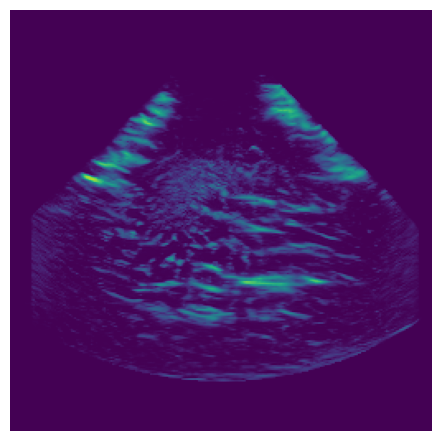

In [10]:
plt.style.use("default")
plt.imshow(x[0].permute(1,2,0).detach().cpu().numpy(), vmin=0, vmax=1)
plt.tight_layout()
plt.axis("off")
plt.show()

In [ ]:
model_cut = cut.CutLinear.load_from_checkpoint("/mnt/raid/C1_ML_Analysis/train_output/ultra-sim/rendering_cut/v2.0/epoch=24-val_loss=3.11.ckpt", num_labels=332)


grid, inverse_grid, mask_fan = model_cut.USR.init_grids(model_cut.hparams.grid_w, model_cut.hparams.grid_h, model_cut.hparams.center_x, model_cut.hparams.center_y, model_cut.hparams.r1, model_cut.hparams.r2, model_cut.hparams.theta)

x = torch.randn(1, 1, 256, 256)
repeats = [1,]*len(x.shape)
repeats[0] = x.shape[0]
grid = grid.repeat(repeats)
inverse_grid = inverse_grid.repeat(repeats)
mask_fan = mask_fan.repeat(repeats)


cut_fn = "/mnt/famli_netapp_shared/C1_ML_Analysis/src/famli-ultra-sim/trained_models/cutLinear_v1.0-ae_v0.4"
USR = model_cut.USR.eval().cuda()
USR.to_torchscript(file_path=cut_fn + "_USR.pt", method="trace", example_inputs=(x.cuda(), grid.cuda(), inverse_grid.cuda(), mask_fan.cuda()))
# model_cut.USR.hparams = model_cut.hparams

G = torch.jit.trace(model_cut.G, x.cuda())